In [1]:
from fastai.basics import *
from fastai.vision.all import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from astropy.io import fits
from astropy.visualization import make_lupton_rgb

rng = np.random.RandomState(256)

In [2]:
PATH = Path("..").resolve()

In [3]:
import sys
sys.path.append(f"{PATH}/src")
from galaxy_dataset import GalaxyDataset, show_images

In [4]:
with fits.open(PATH / 'data/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-noisy.fits') as h:
    X = tensor(np.asarray(h[0].data).astype('float32'))
    y = tensor(np.asarray(h[1].data).astype('float32'))

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=rng, shuffle=True)

In [6]:
image_means = X_train[:100].mean(dim=(0, 2, 3))
image_stds = X_train[:100].std(dim=(0, 2, 3))

In [7]:
transforms_train = Pipeline([ToTensor, Dihedral, Normalize.from_stats(image_means, image_stds)])
transforms_valid = Pipeline([ToTensor, Normalize.from_stats(image_means, image_stds)])

In [8]:
dset_train = GalaxyDataset(X_train, y_train, transform=transforms_train)
dset_valid = GalaxyDataset(X_valid, y_valid, transform=transforms_valid)

dls = ImageDataLoaders.from_dsets(dset_train, dset_valid, device='cuda')

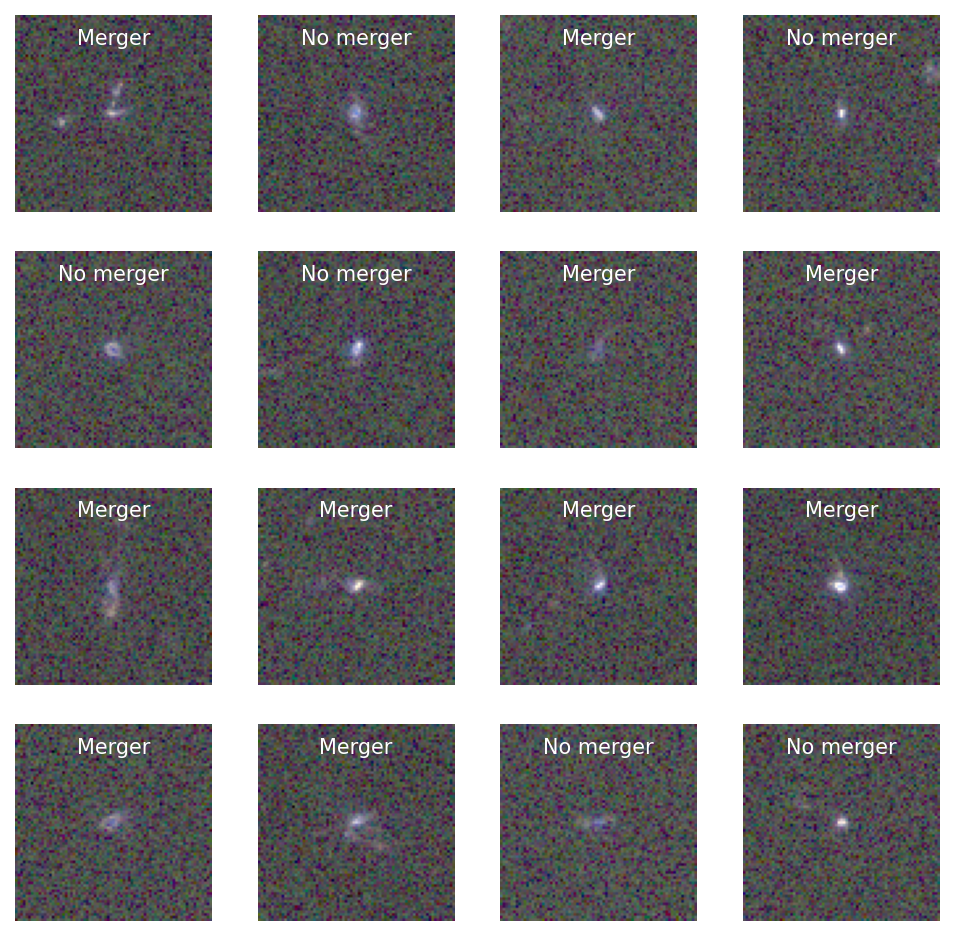

In [9]:
show_images(dset_train[:16])

# Train using resnet

In [19]:
from xresnet_hybrid import xresnet18_hybrid, xresnet34_hybrid, xresnet50_hybrid, XResNet_hybrid

In [42]:
model = xresnet50_hybrid(act_cls=Mish, sa=True, n_out=dls.c)

In [43]:
learn = Learner(
    dls, 
    model, 
    loss_func=CrossEntropyLossFlat(), 
    opt_func=ranger,
    metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()]
)

learn.cuda();

In [45]:
learn.fit_flat_cos(20, 0.1, wd=0.03, div_final=100)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.720250,0.688540,0.530899,0.133829,0.814070,0.229869,0.602908,00:13
1,0.609194,0.631744,0.684529,0.562577,0.772547,0.651052,0.742730,00:13
2,0.565115,0.567828,0.706137,0.628666,0.767524,0.691190,0.790346,00:13
3,0.579642,0.613278,0.691443,0.740190,0.691625,0.715084,0.768203,00:13
4,0.635404,0.842196,0.554451,0.985543,0.540675,0.698273,0.764032,00:13
5,0.531866,0.637125,0.682584,0.452705,0.883871,0.598744,0.813443,00:13
6,0.607952,0.866555,0.581461,0.973152,0.557237,0.708678,0.780931,00:13
7,0.536043,0.607661,0.646500,0.930607,0.605482,0.733637,0.801222,00:13
8,0.562823,0.611578,0.706785,0.599339,0.789445,0.681381,0.782745,00:13
9,0.579841,1.293004,0.613872,0.364725,0.780035,0.497045,0.695105,00:13
